## Imports

In [50]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

settings = {'device': device,
            'dtype': torch.float}

In [52]:
device

'cpu'

## Load Data

In [53]:
BS = 64 #  Batch Size

In [54]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0., 0., 0.], [1., 1., 1.])])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0., 0., 0.], [1., 1., 1.])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Model Definition

Here I have changed some things:
<ul>
<li>add DropOut to prevent overfitting (yields a small improvement)</li>
<li>apply Log Softmax to output</li>

In [56]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128,
                               kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256,
                               kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512,
                               kernel_size=3, padding=2)

        self.lin1 = nn.Linear(512 * 2 * 2, 1024)
        self.lin2 = nn.Linear(1024, 10)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.avg_pool2d(x, 2)
        x = x.view(-1, 512 * 2 * 2)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.lin2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [57]:
def train_model(model, optimizer, criterion, trainloader, testloader, device,
                EPOCHS=100, verbose=True, check_validation=True):
    print('Training')
    t0 = time.perf_counter()
    for epoch in range(EPOCHS):
        model.train()
        m_loss = 0.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if device == 'cuda':
                inputs = inputs.to(device)
                labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            m_loss += loss.detach().item()
        scheduler.step()# UPDATES LEARNING RATE
        if verbose:
            print(f'\nEpoch {epoch + 1}/{EPOCHS} ---> Loss: {m_loss / i:.5f} | Time per epoch {(time.perf_counter() - t0) / (epoch + 1):.2f}s | lr: {optimizer.param_groups[0]["lr"]:.6f}', end='')
        if check_validation:# Runs predictions over the validation dataset to monitor accuracy
            val_loss = 0.
            val_correct = 0
            model.eval()
            with torch.no_grad():
                for j, val_data in enumerate(testloader, 0):
                    val_inputs, val_labels = val_data
                    if device == 'cuda':
                        val_inputs = val_inputs.to(device)
                        val_labels = val_labels.to(device)

                    val_outputs = model(val_inputs)
                    val_pred_labs = val_outputs.argmax(dim=1)
                    val_loss = criterion(val_outputs, val_labels)
                    val_loss += val_loss.detach().item()
                    val_correct += (val_labels == val_outputs.argmax(dim=1)).float().sum()
            print(f' | val_loss: {val_loss / j:.5f} | val_acc: {val_correct / testset.data.shape[0]:.4f}', end='')
        if epoch % 10 == 9:
            print('\n', end='')
    print('\nFinished Training')

### Now we train if we don't find pretrained weights

In [58]:
model = ConvNet()
criterion = nn.NLLLoss()
if device == 'cuda':
    model.cuda()
try:
    model.load_state_dict(
        torch.load(
            '../models/model_state.pt',
            map_location=torch.device(device)
        )
    )
except Exception as e:
    print(f"Found exception: {e}\nLet's train a new model!")
    EPOCHS = 100
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1,
                                          gamma=0.95, last_epoch=-1)
    # Train model
    #train_model(model, optimizer, criterion, trainloader,
    #            testloader, device, EPOCHS=EPOCHS)
    #torch.save(model.state_dict(), './model_state.pth')

## Let's perform a FGSM attack

In [59]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    x_perturbed = x_original + epsilon*grad_sign
    return x_perturbed

In [60]:
epsilons = torch.Tensor([0.5, 0.3, 0.1, 0.05, 0.01, 0.001])
acc_results = dict()
verbose = False
N_VAL_SAMPLES = testset.data.shape[0]
model.eval()
for eps in epsilons:
    perturbed_classification = np.empty((1, 1))
    original_classification = np.empty((1, 1))
    correct_unperturbed = 0
    correct_perturbed = 0
    t0 = time.perf_counter()
    for j, val_data in enumerate(validation_loader, 0):
        ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
        x, y_target = val_data
        x, y_target = x.to(device), y_target.to(device)
        x.requires_grad = True
        output = model(x)
        # Store the predicted label
        y_pred = torch.argmax(output)
        if y_pred == y_target:#Only make attack on correctly classified samples
            correct_unperturbed += 1
            original_classification = np.concatenate([original_classification, y_pred.cpu().numpy().reshape(-1,1)], axis=1)
            # Calculate loss and gradient
            loss = criterion(output, y_target)
            grad = torch.autograd.grad(outputs=loss, inputs=x)[0]
            model.zero_grad()
            perturbed_x = fgsm_attack(x, epsilon=eps, gradient=grad)
            perturbed_output = model(perturbed_x)
            y_pred_perturbed = torch.argmax(perturbed_output)
            loss_perturbed = criterion(perturbed_output, y_target)
            perturbed_classification = np.concatenate([perturbed_classification, y_pred_perturbed.cpu().numpy().reshape(-1,1)], axis=1)
            if y_pred_perturbed == y_target:
                correct_perturbed += 1
    acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
    acc_after_attack = correct_perturbed / N_VAL_SAMPLES
    print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
    print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
    acc_results[eps.item()] = acc_after_attack
acc_results[0] = acc_before_attack


FGSM Attack with epsilon = 0.50000 | Elapsed time: 1333.43 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 12.83%

FGSM Attack with epsilon = 0.30000 | Elapsed time: 1174.49 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 14.16%

FGSM Attack with epsilon = 0.10000 | Elapsed time: 1323.81 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 16.40%

FGSM Attack with epsilon = 0.05000 | Elapsed time: 1309.87 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 16.29%

FGSM Attack with epsilon = 0.01000 | Elapsed time: 1142.43 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 33.69%

FGSM Attack with epsilon = 0.00100 | Elapsed time: 1243.97 seconds.
Accuracy: Before the attack -> 86.42%	|	After the attack -> 79.66%


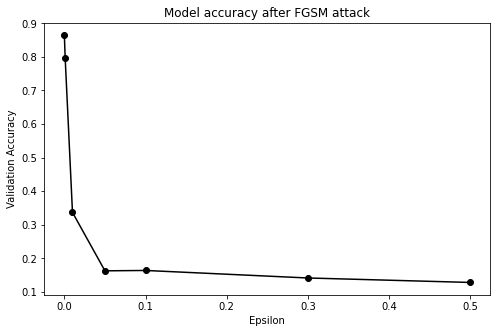

In [61]:
to_plot = [list(acc_results.keys()), list(acc_results.values())]
plt.figure(figsize=(8, 5))
plt.plot(to_plot[0], to_plot[1], '-ok')
plt.title('Model accuracy after FGSM attack')
plt.xlabel('Epsilon')
plt.ylabel('Validation Accuracy')
plt.show()